In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook                    #importing all packages and libraries
from keras.utils import np_utils
%matplotlib inline

C:\Users\arinj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Creating numpy matrices after feature subtraction and concatenation

In [2]:
path = '../GSC-Dataset/GSC-Features-Data/'
gsc = pd.read_csv(path + 'GSC-Features.csv', sep=',', header=0)
gsc.set_index('img_id', inplace = True)
gsc_sp = pd.read_csv(path + 'same_pairs.csv', sep=',', header=0, usecols=[0,1])
gsc_dfn = pd.read_csv(path + 'diffn_pairs.csv', sep=',', header=0, usecols=[0,1])


In [3]:
gsc_sp_concat = np.empty((0,1024), int)
gsc_sp_diff = np.empty((0,512), int)
gsc_dp_concat = np.empty((0,1024), int)
gsc_dp_diff = np.empty((0,512), int)
for i in range(1,5001):                                 #taking only 5000 data out of 790000
    img_id_A = gsc_sp.loc[i][0]
    img_id_B = gsc_sp.loc[i][1]
    try:
        concat = np.append(gsc.loc[img_id_A], gsc.loc[img_id_B])
        diff = np.subtract(gsc.loc[img_id_A], gsc.loc[img_id_B])
        gsc_sp_concat = np.append(gsc_sp_concat, [concat], axis=0)
        gsc_sp_diff = np.append(gsc_sp_diff, [diff], axis=0)
    except:
        continue
        
np.savetxt('same_pair_concat_pickle.csv', gsc_sp_concat, delimiter=',')
np.savetxt('same_pair_diff_pickle.csv', gsc_sp_diff, delimiter=',')

In [4]:
for i in range(1,5001):
    img_id_A = gsc_dfn.loc[i][0]
    img_id_B = gsc_dfn.loc[i][1]
    try:
        concat = np.append(gsc.loc[img_id_A], gsc.loc[img_id_B])
        diff = np.subtract(gsc.loc[img_id_A], gsc.loc[img_id_B])
        gsc_dp_concat = np.append(gsc_dp_concat, [concat], axis=0)
        gsc_dp_diff = np.append(gsc_dp_diff, [diff], axis=0)
    except:
        continue
        
np.savetxt('diff_pair_concat_pickle.csv', gsc_sp_concat, delimiter=',')
np.savetxt('diff_pair_diff_pickle.csv', gsc_sp_diff, delimiter=',')

In [5]:
df = pd.read_csv("same_pair_concat_pickle.csv" , header=None)
df['1024'] = '1'
df.to_csv('same_pair_concat_pickle_with_ones.csv', header=False, index=False)

df = pd.read_csv("same_pair_diff_pickle.csv" , header=None)
df['512'] = '1'
df.to_csv('same_pair_diff_pickle_with_ones.csv', header=False, index=False)

df = pd.read_csv("diff_pair_concat_pickle.csv" , header=None)
df['1024'] = '0'
df.to_csv('diff_pair_concat_pickle_with_zeroes.csv', header=False, index=False)

df = pd.read_csv("diff_pair_diff_pickle.csv" , header=None)
df['512'] = '0'
df.to_csv('diff_pair_diff_pickle_with_zeroes.csv', header=False, index=False)

dp_concat_temp = pd.read_csv('diff_pair_concat_pickle_with_zeroes.csv', sep=',')
dp_diff_temp = pd.read_csv('diff_pair_diff_pickle_with_zeroes.csv', sep=',')
sp_concat_temp = pd.read_csv('same_pair_concat_pickle_with_ones.csv', sep=',')
sp_diff_temp = pd.read_csv('same_pair_diff_pickle_with_ones.csv', sep=',')

a = np.array(dp_concat_temp)
b = np.array(dp_diff_temp)
c = np.array(sp_concat_temp[:2001])
d = np.array(sp_diff_temp[:2001])

concat_matrix=np.concatenate((c,a),axis=0)
np.random.shuffle(concat_matrix)
diff_matrix=np.concatenate((d,b),axis=0)
np.random.shuffle(diff_matrix)

np.savetxt('concat_matrix_pickle.csv', concat_matrix, delimiter=',')
np.savetxt('diff_matrix_pickle.csv', diff_matrix, delimiter=',')

# Partitioning data into training, validation and testing

In [6]:
target_con = pd.read_csv('concat_matrix_pickle.csv', sep=',', header=None, usecols=[1024])
target_vector_concat=np.array(target_con)
target_dif = pd.read_csv('diff_matrix_pickle.csv', sep=',', header=None, usecols=[512])
target_vector_diff=np.array(target_dif)

In [7]:
def TrainingData(given_matrix,given_target):
    n, m = given_matrix.shape
    n_train = int(0.9 * n)
    n_valid = int((n - n_train) / 2)

    x_train = given_matrix.loc[:n_train, :]
    return x_train

def ValidationData(given_matrix,given_target):
    n, m = given_matrix.shape
    n_train = int(0.9 * n)
    n_valid = int((n - n_train) / 2)

    x_valid = given_matrix.loc[n_train:n_train + n_valid, :]
    return x_valid

def TestingData(given_matrix,given_target):
    n, m = given_matrix.shape
    n_train = int(0.9 * n)
    n_valid = int((n - n_train) / 2)

    x_test = given_matrix.loc[n_train + n_valid:, :]
    return x_test


def TrainingVector(given_matrix,given_target):
    n, m = given_matrix.shape
    n_train = int(0.9 * n)
    n_valid = int((n - n_train) / 2)

    y_train = given_target[:n_train, :]
    return y_train


def ValidationVector(given_matrix,given_target):
    n, m = given_matrix.shape
    n_train = int(0.9 * n)
    n_valid = int((n - n_train) / 2)

    y_valid = given_target[n_train:n_train + n_valid, :]
    return y_valid


def TestingVector(given_matrix,given_target):
    n, m = given_matrix.shape
    n_train = int(0.9 * n)
    n_valid = int((n - n_train) / 2)

    y_test = given_target[n_train + n_valid:, :]
    return y_test

   

In [8]:
concat_data = pd.read_csv('concat_matrix_pickle.csv', sep=',', header=None, usecols=range(1024))
diff_data = pd.read_csv('diff_matrix_pickle.csv', sep=',', header=None, usecols=range(512))
diff_data = diff_data.abs()

In [9]:
print('###################### Concatenation ##########################')

concat_train_data = TrainingData(concat_data,target_vector_concat) 
print(concat_train_data.shape)
concat_valid_data = ValidationData(concat_data,target_vector_concat) 
print(concat_valid_data.shape)
concat_test_data = TestingData(concat_data,target_vector_concat) 
print(concat_test_data.shape)
concat_train_vector = TrainingVector(concat_data,target_vector_concat) 
print(concat_train_vector.shape)
concat_valid_vector = ValidationVector(concat_data,target_vector_concat) 
print(concat_valid_vector.shape)
concat_test_vector = TestingVector(concat_data,target_vector_concat) 
print(concat_test_vector.shape)

print('###################### Subtraction ############################')

diff_train_data = TrainingData(diff_data,target_vector_diff) 
print(diff_train_data.shape)
diff_valid_data = ValidationData(diff_data,target_vector_diff) 
print(diff_valid_data.shape)
diff_test_data = TestingData(diff_data,target_vector_diff) 
print(diff_test_data.shape)
diff_train_vector = TrainingVector(diff_data,target_vector_diff) 
print(diff_train_vector.shape)
diff_valid_vector = ValidationVector(diff_data,target_vector_diff) 
print(diff_valid_vector.shape)
diff_test_vector = TestingVector(diff_data,target_vector_diff) 
print(diff_test_vector.shape)


###################### Concatenation ##########################
(6301, 1024)
(351, 1024)
(350, 1024)
(6300, 1)
(350, 1)
(350, 1)
###################### Subtraction ############################
(6301, 512)
(351, 512)
(350, 512)
(6300, 1)
(350, 1)
(350, 1)


# Performing Linear Regression

In [10]:
maxAcc = 0.0
maxIter = 0
TrainingPercent = 90
ValidationPercent = 5
TestPercent = 5
M = 100
PHI = []
IsSynthetic = False

In [11]:
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,(len(VAL_TEST_OUT)-1)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

def GetAccuracy(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,(len(VAL_TEST_OUT)-1)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    return (str(accuracy))

In [12]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(concat_train_data)
Mu = kmeans.cluster_centers_

concat_data_T = np.array(np.transpose(concat_data))
concat_test_data_T = np.array(np.transpose(concat_test_data))
concat_valid_data_T = np.array(np.transpose(concat_valid_data))

BigSigma1     = GenerateBigSigma(concat_data_T, Mu, TrainingPercent,IsSynthetic)

BigSigma =    np.identity(len(BigSigma1))*0.2 + BigSigma1

TRAINING_PHI = GetPhiMatrix(concat_data_T, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(concat_test_data_T, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(concat_valid_data_T, Mu, BigSigma, 100)
W            = np.random.rand(M,)

print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)



(100, 1024)
(1024, 1024)
(6300, 100)
(100,)
(351, 100)
(350, 100)


In [13]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
TrainingTarget = (np.transpose(concat_train_vector)).flatten()
ValDataAct = np.array(concat_valid_vector)
TestDataAct = np.array(concat_test_vector)

for i in range(0,1000):
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    Acc_TR        = GetAccuracy(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    Acc_Val       = GetAccuracy(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test     = GetErms(TEST_OUT,TestDataAct)
    Acc_Test      = GetAccuracy(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [14]:
print ('--------------------LINEAR REGRESSION------------------------------------')
print ('----------Gradient Descent Solution for Concatenation--------------------')
print ("M = 100 \nLambda  = 2\neta = 0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),8)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),8)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),8)))
print ("Training Accuracy = " + Acc_TR + "%")
print ("Validation Accuracy = " + Acc_Val + "%")
print ("Testing Accuracy = " + Acc_Test + "%")
print ('-------------------------------------------------------------------------')

--------------------LINEAR REGRESSION------------------------------------
----------Gradient Descent Solution for Concatenation--------------------
M = 100 
Lambda  = 2
eta = 0.01
E_rms Training   = 0.44302122
E_rms Validation = 0.43192941
E_rms Testing    = 0.46094831
Training Accuracy = 71.46031746031746%
Validation Accuracy = 72.07977207977208%
Testing Accuracy = 69.14285714285714%
-------------------------------------------------------------------------


In [15]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(diff_train_data)
Mu = kmeans.cluster_centers_

diff_data_T = np.array(np.transpose(diff_data))
diff_test_data_T = np.array(np.transpose(diff_test_data))
diff_valid_data_T = np.array(np.transpose(diff_valid_data))

BigSigma1     = GenerateBigSigma(diff_data_T, Mu, TrainingPercent,IsSynthetic)

BigSigma =    np.identity(len(BigSigma1))*0.2 + BigSigma1

TRAINING_PHI = GetPhiMatrix(diff_data_T, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(diff_test_data_T, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(diff_valid_data_T, Mu, BigSigma, 100)
W            = np.random.rand(M,)

print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)


(100, 512)
(512, 512)
(6300, 100)
(100,)
(351, 100)
(350, 100)


In [16]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
TrainingTarget = (np.transpose(diff_train_vector)).flatten()
ValDataAct = np.array(diff_valid_vector)
TestDataAct = np.array(diff_test_vector)

for i in range(0,1000):
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
     #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    Acc_TR        = GetAccuracy(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    Acc_Val       = GetAccuracy(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test     = GetErms(TEST_OUT,TestDataAct)
    Acc_Test      = GetAccuracy(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [17]:
print ('--------------------LINEAR REGRESSION----------------------------------')
print ('----------Gradient Descent Solution for Subtraction--------------------')
print ("M = 100 \nLambda  = 2\neta = 0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),8)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),8)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),8)))
print ("Training Accuracy = " + Acc_TR + "%")
print ("Validation Accuracy = " + Acc_Val + "%")
print ("Testing Accuracy = " + Acc_Test + "%")
print ('-------------------------------------------------------------------------')

--------------------LINEAR REGRESSION----------------------------------
----------Gradient Descent Solution for Subtraction--------------------
M = 100 
Lambda  = 2
eta = 0.01
E_rms Training   = 0.44675744
E_rms Validation = 0.44174172
E_rms Testing    = 0.43513031
Training Accuracy = 71.2063492063492%
Validation Accuracy = 72.07977207977208%
Testing Accuracy = 73.71428571428571%
-------------------------------------------------------------------------


# Performing Logistic Regression

In [18]:
def sigmoid(parameter):
    return (1/(1+(np.exp(-1*parameter))))

def predict(features, weights):
    z = np.dot(features, weights)
    answer = sigmoid(z)
    return answer

def cost_function(features, labels, weights):
    observations = len(labels)

    predictions = predict(features, weights)
    
    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)
    
    #Take the error when label=0
    class2_cost = (1-labels)*np.log(1-predictions)
    
    #Take the sum of both costs
    cost = class1_cost - class2_cost

    #Take the average cost
    cost = cost.sum()/observations

    return cost

def update_weights(features, labels, weights, lr):
    
    N = len(features)

    #1 - Get Predictions
    predictions = predict(features, weights)

    #2 Transpose features 
    gradient = np.dot(features.T,  predictions - labels)

    #3 Take the average cost derivative for each feature
    gradient /= N

    #4 - Multiply the gradient by our learning rate
    gradient *= lr

    #5 - Subtract from our weights to minimize cost
    weights -= gradient

    return weights

def train_logistic_weight(features, labels, weights, lr, iters):
    cost_history = []

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)

    return weights

def train_logistic_cost(features, labels, weights, lr, iters):
    cost_history = []

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)

    return cost_history

def accuracy_Logistic(predicted_labels, actual_labels):
    count = 0
    a = actual_labels
    b = np.array(predicted_labels)
    c = np.absolute(b)
    d = np.around(c)
    
    for i in range(len(a)):
        if (a[i]  == d[i]):
            count += 1
    
    return (1-(count/len(a)))*100

def Erms_Logistic(VAL_TEST_OUT,cost_last):
    return (math.sqrt(2*cost_last/len(VAL_TEST_OUT)))


In [19]:
W_Logistic        = np.dot(220, W_Now)
concat_data_T = np.array(np.transpose(concat_data))
concat_test_data_T = np.array(np.transpose(concat_test_data))
concat_valid_data_T = np.array(np.transpose(concat_valid_data))

kmeans = KMeans(n_clusters=M, random_state=0).fit(concat_train_data)
Mu = kmeans.cluster_centers_

BigSigma1     = GenerateBigSigma(concat_data_T, Mu, TrainingPercent,IsSynthetic)

BigSigma =    np.identity(len(BigSigma1))*0.2 + BigSigma1

TRAINING_PHI = GetPhiMatrix(concat_data_T, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(concat_test_data_T, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(concat_valid_data_T, Mu, BigSigma, 100)

TrainingTarget = (np.transpose(concat_train_vector)).flatten()
ValDataAct = np.array(concat_valid_vector)
TestDataAct = np.array(concat_test_vector)

current_w = train_logistic_weight(TRAINING_PHI,TrainingTarget,W_Logistic,0.01,2000)
current_cost_hist = train_logistic_cost(TRAINING_PHI,TrainingTarget,W_Logistic,0.01,2000)

#-----------------TrainingData---------------------#
TR_TEST_OUT   = GetValTest(TRAINING_PHI,current_w) 
Erms_TR       = Erms_Logistic(TR_TEST_OUT,current_cost_hist[-1])
Acc_TR        = accuracy_Logistic(TR_TEST_OUT,TrainingTarget)
        
#-----------------ValidationData---------------------#
VAL_TEST_OUT  = GetValTest(VAL_PHI,current_w) 
Erms_Val      = Erms_Logistic(VAL_TEST_OUT,current_cost_hist[-1])
Acc_Val       = accuracy_Logistic(VAL_TEST_OUT,ValDataAct)
    
#-----------------TestingData---------------------#
TEST_OUT      = GetValTest(TEST_PHI,current_w) 
Erms_Test     = Erms_Logistic(TEST_OUT,current_cost_hist[-1])
Acc_Test      = accuracy_Logistic(TEST_OUT,TestDataAct)
    

In [20]:
print ('--------------------LOGISTIC REGRESSION------------------------------------')
print ('----------Gradient Descent Solution for Concatenation--------------------')
print ("M = 100 \nIteration  = 2000\neta = 0.01")
print ("E_rms Training   = " + str(Erms_TR))
print ("E_rms Validation = " + str(Erms_Val))
print ("E_rms Testing    = " + str(Erms_Test))
print ("Training Accuracy = " + str(Acc_TR) + "%")
print ("Validation Accuracy = " + str(Acc_Val) + "%")
print ("Testing Accuracy = " + str(Acc_Test) + "%")
print ('-------------------------------------------------------------------------')

--------------------LOGISTIC REGRESSION------------------------------------
----------Gradient Descent Solution for Concatenation--------------------
M = 100 
Iteration  = 2000
eta = 0.01
E_rms Training   = 0.015211089975801267
E_rms Validation = 0.06444319318680147
E_rms Testing    = 0.06453518922676675
Training Accuracy = 37.25396825396825%
Validation Accuracy = 31.14285714285714%
Testing Accuracy = 39.142857142857146%
-------------------------------------------------------------------------


In [21]:
W_Logistic        = np.dot(220, W_Now)
diff_data_T = np.array(np.transpose(diff_data))
diff_test_data_T = np.array(np.transpose(diff_test_data))
diff_valid_data_T = np.array(np.transpose(diff_valid_data))

kmeans = KMeans(n_clusters=M, random_state=0).fit(diff_train_data)
Mu = kmeans.cluster_centers_

BigSigma1     = GenerateBigSigma(diff_data_T, Mu, TrainingPercent,IsSynthetic)

BigSigma =    np.identity(len(BigSigma1))*0.2 + BigSigma1

TRAINING_PHI = GetPhiMatrix(diff_data_T, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(diff_test_data_T, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(diff_valid_data_T, Mu, BigSigma, 100)

TrainingTarget = (np.transpose(diff_train_vector)).flatten()
ValDataAct = np.array(diff_valid_vector)
TestDataAct = np.array(diff_test_vector)

current_w = train_logistic_weight(TRAINING_PHI,TrainingTarget,W_Logistic,0.01,2000)
current_cost_hist = train_logistic_cost(TRAINING_PHI,TrainingTarget,W_Logistic,0.01,2000)

#-----------------TrainingData---------------------#
TR_TEST_OUT   = GetValTest(TRAINING_PHI,current_w) 
Erms_TR       = Erms_Logistic(TR_TEST_OUT,current_cost_hist[-1])
Acc_TR        = accuracy_Logistic(TR_TEST_OUT,TrainingTarget)
        
#-----------------ValidationData---------------------#
VAL_TEST_OUT  = GetValTest(VAL_PHI,current_w) 
Erms_Val      = Erms_Logistic(VAL_TEST_OUT,current_cost_hist[-1])
Acc_Val       = accuracy_Logistic(VAL_TEST_OUT,ValDataAct)
    
#-----------------TestingData---------------------#
TEST_OUT      = GetValTest(TEST_PHI,current_w) 
Erms_Test     = Erms_Logistic(TEST_OUT,current_cost_hist[-1])
Acc_Test      = accuracy_Logistic(TEST_OUT,TestDataAct)
    

C:\Users\arinj\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\Users\arinj\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


In [22]:
print ('--------------------LOGISTIC REGRESSION------------------------------------')
print ('----------Gradient Descent Solution for Subtraction--------------------')
print ("M = 100 \nIteration  = 2000\neta = 0.01")
print ("E_rms Training   = " + str(Erms_TR))
print ("E_rms Validation = " + str(Erms_Val))
print ("E_rms Testing    = " + str(Erms_Test))
print ("Training Accuracy = " + str(Acc_TR) + "%")
print ("Validation Accuracy = " + str(Acc_Val) + "%")
print ("Testing Accuracy = " + str(Acc_Test) + "%")
print ('-------------------------------------------------------------------------')

--------------------LOGISTIC REGRESSION------------------------------------
----------Gradient Descent Solution for Subtraction--------------------
M = 100 
Iteration  = 2000
eta = 0.01
E_rms Training   = 0.014028957762318956
E_rms Validation = 0.059434980446822015
E_rms Testing    = 0.05951982700029232
Training Accuracy = 61.92063492063492%
Validation Accuracy = 63.142857142857146%
Testing Accuracy = 66.57142857142857%
-------------------------------------------------------------------------


# Performing neural network

In [23]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 1024])
outputTensor = tf.placeholder(tf.float32, [None, 1])

In [24]:
NUM_HIDDEN_NEURONS_LAYER_1 = 100
NUM_HIDDEN_NEURONS_LAYER_2 = 100

LEARNING_RATE = 1

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

#2 hidden layer
input_hidden_weights  = init_weights([1024, NUM_HIDDEN_NEURONS_LAYER_1])

#initializing the hidden layer 1 to output layer weights 1
hidden_output_weights1 = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, NUM_HIDDEN_NEURONS_LAYER_2])

#initializing the input to hidden layer 2 weights
input_hidden_weights2 = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, NUM_HIDDEN_NEURONS_LAYER_2])

#initializing the output to hidden layer 2 weights
hidden_output_weights2 = init_weights([NUM_HIDDEN_NEURONS_LAYER_2, 1])

# Computing values at the hidden layer 1
hidden_layer1 = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))

#computing values at the hidden layer 2
hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, input_hidden_weights2))

# Computing values at the output layer
output_layer = tf.matmul(hidden_layer2, hidden_output_weights2)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.round(tf.sigmoid(output_layer))

In [25]:
NUM_OF_EPOCHS = 5000
BATCH_SIZE = 128

processedTrainingData = np.array(concat_train_data)
processedTrainingLabel = np.array(concat_train_vector)
processedTestingData = np.array(concat_test_data)
processedTestingLabel = np.array(concat_test_vector)

training_accuracy = []

with tf.Session() as sess:
    
    # Set Global Variables ?
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.array(np.random.permutation(range(len(processedTrainingData)-1)),dtype='int')
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

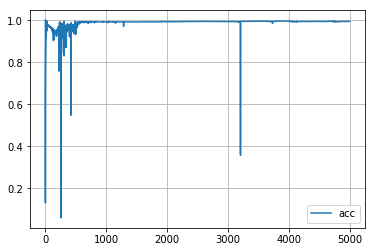

In [26]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [27]:
wrong   = 0
right   = 0
predictedTestLabelList = []

""
for i,j in zip(processedTestingLabel,predictedTestLabel):
    #predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1
print ('--------------------NEURAL NETWORKS------------------------------------')
print ('---------------------Concatenation-------------------------------------')

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100) + "%")
print('-------------------------------------------------------------------------')



--------------------NEURAL NETWORKS------------------------------------
---------------------Concatenation-------------------------------------
Errors: 15  Correct :335
Testing Accuracy: 95.71428571428572%
-------------------------------------------------------------------------


In [28]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 512])
outputTensor = tf.placeholder(tf.float32, [None, 1])

In [29]:
NUM_HIDDEN_NEURONS_LAYER_1 = 100
NUM_HIDDEN_NEURONS_LAYER_2 = 100

LEARNING_RATE = 1

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

#2 hidden layer
input_hidden_weights  = init_weights([512, NUM_HIDDEN_NEURONS_LAYER_1])

#initializing the hidden layer 1 to output layer weights 1
hidden_output_weights1 = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, NUM_HIDDEN_NEURONS_LAYER_2])

#initializing the input to hidden layer 2 weights
input_hidden_weights2 = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, NUM_HIDDEN_NEURONS_LAYER_2])

#initializing the output to hidden layer 2 weights
hidden_output_weights2 = init_weights([NUM_HIDDEN_NEURONS_LAYER_2, 1])

# Computing values at the hidden layer 1
hidden_layer1 = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))

#computing values at the hidden layer 2
hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, input_hidden_weights2))

# Computing values at the output layer
output_layer = tf.matmul(hidden_layer2, hidden_output_weights2)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.round(tf.sigmoid(output_layer))

In [30]:
NUM_OF_EPOCHS = 5000
BATCH_SIZE = 128

processedTrainingData = np.array(diff_train_data)
processedTrainingLabel = np.array(diff_train_vector)
processedTestingData = np.array(diff_test_data)
processedTestingLabel = np.array(diff_test_vector)

training_accuracy = []

with tf.Session() as sess:
    
    # Set Global Variables ?
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.array(np.random.permutation(range(len(processedTrainingData)-1)),dtype='int')
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

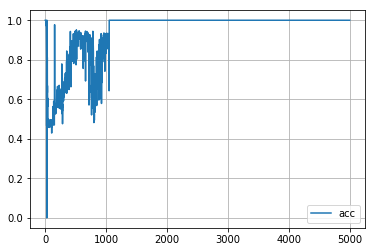

In [31]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [32]:
wrong   = 0
right   = 0
predictedTestLabelList = []

""
for i,j in zip(processedTestingLabel,predictedTestLabel):
    #predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1
print ('--------------------NEURAL NETWORKS------------------------------------')
print ('-----------------------Subtraction-------------------------------------')

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100) +"%")
print('-------------------------------------------------------------------------')



--------------------NEURAL NETWORKS------------------------------------
-----------------------Subtraction-------------------------------------
Errors: 0  Correct :350
Testing Accuracy: 100.0%
-------------------------------------------------------------------------


In [33]:
print('-------------------------------------------------------------------------')
print('-------------------------------------------------------------------------')
print ('------------------------THE END-----------------------------------------')
print('-------------------------------------------------------------------------')
print('-------------------------------------------------------------------------')


-------------------------------------------------------------------------
-------------------------------------------------------------------------
------------------------THE END-----------------------------------------
-------------------------------------------------------------------------
-------------------------------------------------------------------------
